Data pre-processing & modeling of factors related to COVID-19 death rate via multiple Machine Learning algorithms. <br>
Track D - Group 5<br>
Written by: Amir Avnit

In [0]:
# Import libraries
from IPython.display import Image
from google.colab import drive, files
from sklearn import tree

from sklearn.ensemble import RandomForestRegressor,GradientBoostingRegressor
from sklearn.linear_model import LinearRegression,BayesianRidge,Ridge, Lasso, ElasticNet
from sklearn.metrics import mean_squared_error,r2_score
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeRegressor
from statsmodels.api import OLS
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import numpy as np
import pandas as pd
import pydotplus
from re import sub
import scipy.stats as sci
import seaborn as sns
 
# Set visualization prefrences 
sns.set(font_scale=1.5, style="darkgrid")

## Data import & preprocessing

In [3]:
# Upload data file.
uploaded = files.upload()

Saving merged.csv to merged (1).csv


In [0]:
# Read into a data frame.
df = pd.read_csv("merged.csv", na_values=['NA','NR'])

In [5]:
# check general info
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2997 entries, 0 to 2996
Data columns (total 60 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   Unnamed: 0                                                                                                2997 non-null   int64  
 1   date                                                                                                      2997 non-null   object 
 2   county                                                                                                    2997 non-null   object 
 3   state                                                                                                     2997 non-null   object 
 4   fips                                                                          

In [6]:
# Drop rows with unknown counties.
df = df[df['county']!= 'Unknown']
df.reset_index(drop=True)

,Unnamed: 0,date,county,state,fips,cases,deaths,confirmed_cases,confirmed_deaths,probable_cases,probable_deaths,POP_ESTIMATE_2018,total_state_pop,Active.Physicians.per.100.000.Population..2018..AAMC.,Total.Active.Patient.Care.Physicians.per.100.000.Population..2018..AAMC.,Active.Primary.Care.Physicians.per.100.000.Population..2018..AAMC.,Active.Patient.Care.Primary.Care.Physicians.per.100.000.Population..2018..AAMC.,Active.General.Surgeons.per.100.000.Population..2018..AAMC.,Active.Patient.Care.General.Surgeons.per.100.000.Population..2018..AAMC.,Percentage.of.Active.Physicians.Who.Are.Female..2018..AAMC.,Percentage.of.Active.Physicians.Who.Are.International.Medical.Graduates..IMGs...2018..AAMC.,Percentage.of.Active.Physicians.Who.Are.Age.60.or.Older..2018..AAMC.,MD.and.DO.Student.Enrollment.per.100.000.Population..AY.2018.2019..AAMC.,Student.Enrollment.at.Public.MD.and.DO.Schools.per.100.000.Population..AY.2018.2019..AAMC.,Percentage.Change.in.Student.Enrollment.at.MD.and.DO.Schools..2008.2018..AAMC.,Percentage.of.MD.Students.Matriculating.In.State..AY.2018.2019..AAMC.,Total.Residents.Fellows.in.ACGME.Programs.per.100.000.Population.as.of.December.31..2018..AAMC.,Total.Residents.Fellows.in.Primary.Care.ACGME.Programs.per.100.000.Population.as.of.Dec..31..2018..AAMC.,Percentage.of.Residents.in.ACGME.Programs.Who.Are.IMGs.as.of.December.31..2018..AAMC.,Ratio.of.Residents.and.Fellows..GME..to.Medical.Students..UME...AY.2017.2018..AAMC.,Percent.Change.in.Residents.and.Fellows.in.ACGME.Accredited.Programs..2008.2018..AAMC.,Percentage.of.Physicians.Retained.in.State.from.Undergraduate.Medical.Education..UME...2018..AAMC.,All.Specialties..AAMC.,State.Local.Government.hospital.beds.per.1000.people..2019.,Non.profit.hospital.beds.per.1000.people..2019.,For.profit.hospital.beds.per.1000.people..2019.,Total.hospital.beds.per.1000.people..2019.,Total.nurse.practitioners..2019.,Total.physician.assistants..2019.,Total.Hospitals..2019.,Total.Primary.Care.Physicians..2019.,Surgery.specialists..2019.,Emergency.Medicine.specialists..2019.,Total.Specialist.Physicians..2019.,ICU.Beds,pop_fraction,Length.of.Life.rank,Quality.of.Life.rank,Health.Behaviors.rank,Clinical.Care.rank,Social...Economic.Factors.rank,Physical.Environment.rank,Adult.smoking.percentage,Adult.obesity.percentage,Excessive.drinking.percentage,Population.per.sq.mile,House.per.sq.mile,Total.Number.of.COVID.19.Tests.with.Results,Share.of.Tests.with.Positive.COVID.19.Results,Number.of.Tests.with.Results.per.1.000.Population
0,1,5/14/2020,Autauga,Alabama,1001.0,93,4.0,93.0,4.0,NaN,NaN,55601.0,9775742.0,217.1,196.7,77.2,71.2,7.6,6.9,28.50%,18.10%,34.40%,49.1,22.8,136.80%,82.10%,29.9,11.9,21.90%,0.6,18.40%,48.40%,120.737436,1.4,0.8,0.9,3.1,28.859137,6.085786,1.148905,66.693385,8.576976,5.289515,72.142154,6.0,0.005688,5.0,11.0,9.0,13.0,7.0,53.0,18.0,33.0,15.0,91.8,37.2,136372.0,0.077853,27.8
1,2,5/14/2020,Baldwin,Alabama,1003.0,231,7.0,231.0,7.0,NaN,NaN,218022.0,9775742.0,217.1,196.7,77.2,71.2,7.6,6.9,28.50%,18.10%,34.40%,49.1,22.8,136.80%,82.10%,29.9,11.9,21.90%,0.6,18.40%,48.40%,473.434243,1.4,0.8,0.9,3.1,113.162114,23.863512,4.505074,261.517333,33.631941,20.741184,282.882982,51.0,0.022302,3.0,2.0,5.0,6.0,3.0,5.0,17.0,31.0,18.0,114.6,65.5,136372.0,0.077853,27.8
2,3,5/14/2020,Barbour,Alabama,1005.0,69,1.0,69.0,1.0,NaN,NaN,24881.0,9775742.0,217.1,196.7,77.2,71.2,7.6,6.9,28.50%,18.10%,34.40%,49.1,22.8,136.80%,82.10%,29.9,11.9,21.90%,0.6,18.40%,48.40%,54.029031,1.4,0.8,0.9,3.1,12.914231,2.723340,0.514126,29.844753,3.838128,2.367015,32.283033,5.0,0.002545,23.0,55.0,54.0,41.0,60.0,28.0,22.0,42.0,13.0,31.0,13.4,136372.0,0.077853,27.8
3,4,5/14/2020,Bibb,Alabama,1007.0,46,1.0,46.0,1.0,NaN,NaN,22400.0,9775742.0,217.1,196.7,77.2,71.2,7.6,6.9,28.50%,18.10%,34.40%,49.1,22.8,136.80%,82.10%,29.9,11.9,21.90%,0.6,18.40%,48.40%,48.641546,1.4,0.8,0.9,3.1,11.626493,2.451783,0.462860,26.868794,3.455410,2.130989,29.063942,0.0,0.002291,49.0,14.0,32.0,18.0,43.0,22.0,19.0,38.0,16.0,36.8,14.4,136372.0,0.0778

In [0]:
# Drop fips & indices columns
df.drop(['fips','Unnamed: 0'],inplace=True,axis=1)

In [0]:
# Drop Total.Number.of.COVID.19.Tests.with.Results, as it is identical to Number.of.Tests.with.Results.per.1.000.Population (but not normalized)
df.drop('Total.Number.of.COVID.19.Tests.with.Results',inplace=True, axis=1)

In [9]:
# Check dates availiable
df['date'].unique()

array(['5/14/2020'], dtype=object)

In [0]:
# Drop dates, as there's only one value.
df.drop(['date'], axis=1, inplace=True);

In [11]:
# Remove rows with Nulls for cases or deaths (y variables)
y_na_n = df.shape[0]
df = df[df['cases'].notna()]
df = df[df['deaths'].notna()]
y_na_n = y_na_n - df.shape[0]
print('# Rows removed: ',str(y_na_n))

# Rows removed:  76


In [12]:
# Remove columns with 25% or more NAs
na_cols = df.columns[df.isna().sum() > df.shape[0]*.25]
print('Columns removed:\n',na_cols)
df = df[df.columns[~df.columns.isin(na_cols)]]

Columns removed:
 Index(['confirmed_deaths', 'probable_cases', 'probable_deaths'], dtype='object')


In [13]:
# Check difference between cases and confirmed cases
print('NAs in cases: ', df['cases'].isna().sum())
print('NAs in confirmed cases: ', df['confirmed_cases'].isna().sum())

print('% different cases: ', sum(df['cases']!=df['confirmed_cases'])/df.shape[0]*100)

NAs in cases:  0
NAs in confirmed cases:  494
% different cases:  22.23374827109267


In [0]:
# Remove confirmed cases, as it has many NAs
df.drop('confirmed_cases', inplace=True, axis=1)

In [15]:
# Check maximal NA % of remaining features
round(np.max(df.isna().sum())/df.shape[0]*100,2)

7.02

In [0]:
non_features = ['county','state','POP_ESTIMATE_2018','total_state_pop', 
                'pop_fraction']

to_be_normalzied_features = ['cases','deaths','All.Specialties..AAMC.',
                             'Total.nurse.practitioners..2019.',
                             'Total.physician.assistants..2019.',
                             'Total.Hospitals..2019.',
                             'Total.Primary.Care.Physicians..2019.',
                             'Surgery.specialists..2019.',
                             'Emergency.Medicine.specialists..2019.',
                             'Total.Specialist.Physicians..2019.',
                             'ICU.Beds',
                             ]

in_percentage = ['Percentage.of.Active.Physicians.Who.Are.Female..2018..AAMC.',
                 'Percentage.of.Active.Physicians.Who.Are.International.Medical.Graduates..IMGs...2018..AAMC.',
                 'Percentage.of.Active.Physicians.Who.Are.Age.60.or.Older..2018..AAMC.',
                 'Percentage.Change.in.Student.Enrollment.at.MD.and.DO.Schools..2008.2018..AAMC.',
                 'Percentage.of.MD.Students.Matriculating.In.State..AY.2018.2019..AAMC.',
                 'Percentage.of.Residents.in.ACGME.Programs.Who.Are.IMGs.as.of.December.31..2018..AAMC.',
                 'Percent.Change.in.Residents.and.Fellows.in.ACGME.Accredited.Programs..2008.2018..AAMC.',
                 'Percentage.of.Physicians.Retained.in.State.from.Undergraduate.Medical.Education..UME...2018..AAMC.',
                 ]

In [0]:
# Convert percentiles into floats
for col_name in in_percentage:
  df[col_name] = df[col_name].apply(lambda x: sub('%','',str(x))).astype(float)

In [0]:
# Normalize features
for feature in to_be_normalzied_features:
  df[feature] = df[feature]*1000/df['POP_ESTIMATE_2018']

In [19]:
# Check all variables, make sure all are numerical.
df[df.columns[~df.columns.isin(non_features)]].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2892 entries, 0 to 2996
Data columns (total 47 columns):
 #   Column                                                                                                    Non-Null Count  Dtype  
---  ------                                                                                                    --------------  -----  
 0   cases                                                                                                     2890 non-null   float64
 1   deaths                                                                                                    2890 non-null   float64
 2   Active.Physicians.per.100.000.Population..2018..AAMC.                                                     2890 non-null   float64
 3   Total.Active.Patient.Care.Physicians.per.100.000.Population..2018..AAMC.                                  2890 non-null   float64
 4   Active.Primary.Care.Physicians.per.100.000.Population..2018..AAMC.            

In [0]:
# Fill all NAs with averages.
df[df.columns[~df.columns.isin(non_features)]] = df[df.columns[~df.columns.isin(non_features)]].fillna(df[df.columns[~df.columns.isin(non_features)]].mean())

In [0]:
# Save csv to Google Drive

# Mount your Drive to the Colab VM
drive.mount('/gdrive')

# Write the DataFrame to CSV file
with open('/gdrive/My Drive/all_vars_for_analysis.csv', 'w') as f:
  df.to_csv(f)

## Feature selection: via random tree gini importance

In [0]:
X = df[df.columns[~df.columns.isin(non_features)]].drop(['cases','deaths'], axis=1) # Exclude deaths & cases from X
y = df['deaths']

In [22]:
# Check number of features
print('# features: ', X.shape[1])

# features:  45


In [23]:
# Verify there are no nulls.
X.isnull().any().any()

False

In [0]:
# Split into training and test data
X_train, X_test, y_train, y_test = train_test_split(X, df['deaths'], test_size=0.25, random_state=10)

In [0]:
# Save csv to Google Drive

# Mount your Drive to the Colab VM
# drive.mount('/gdrive')

# Write train and test sets into csv files:
# with open('/gdrive/My Drive/X_train.csv', 'w') as f:
#   X_train.to_csv(f)
# with open('/gdrive/My Drive/y_train.csv', 'w') as f:
#   y_train.to_csv(f)
# with open('/gdrive/My Drive/X_test.csv', 'w') as f:
#   X_test.to_csv(f)
# with open('/gdrive/My Drive/y_test.csv', 'w') as f:
#   y_test.to_csv(f)

In [0]:
# train random forst
n_trees= 1000

rf = RandomForestRegressor(n_estimators=n_trees, oob_score=True, random_state=10)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=None, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=True,
                      random_state=10, verbose=0, warm_start=False)

In [0]:
Importances_df = pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rf.feature_importances_), 
                                         df[df.columns[~df.columns.isin(non_features)]].columns), 
                                     reverse=True), columns=['Gini Importence', 'Name'])

In [0]:
# Save Importances as csv to Google Drive

# Mount your Drive to the Colab VM
# drive.mount('/gdrive')

# Write the DataFrame to CSV file
with open('/gdrive/My Drive/Feature_Importances-predicting_deaths.csv', 'w') as f:
  Importances_df.to_csv(f)

In [0]:
Importances_df 

,Gini Importence,Name
0,0.1280,ICU.Beds
1,0.0916,Adult.obesity.percentage
2,0.0711,Population.per.sq.mile
3,0.0675,Excessive.drinking.percentage
4,0.0669,Quality.of.Life.rank
5,0.0647,Health.Behaviors.rank
6,0.0544,Physical.Environment.rank
7,0.0542,Clinical.Care.rank
8,0.0462,Adult.smoking.percentage
9,0.0459,Length.of.Life.rank


## Correlation Analysis

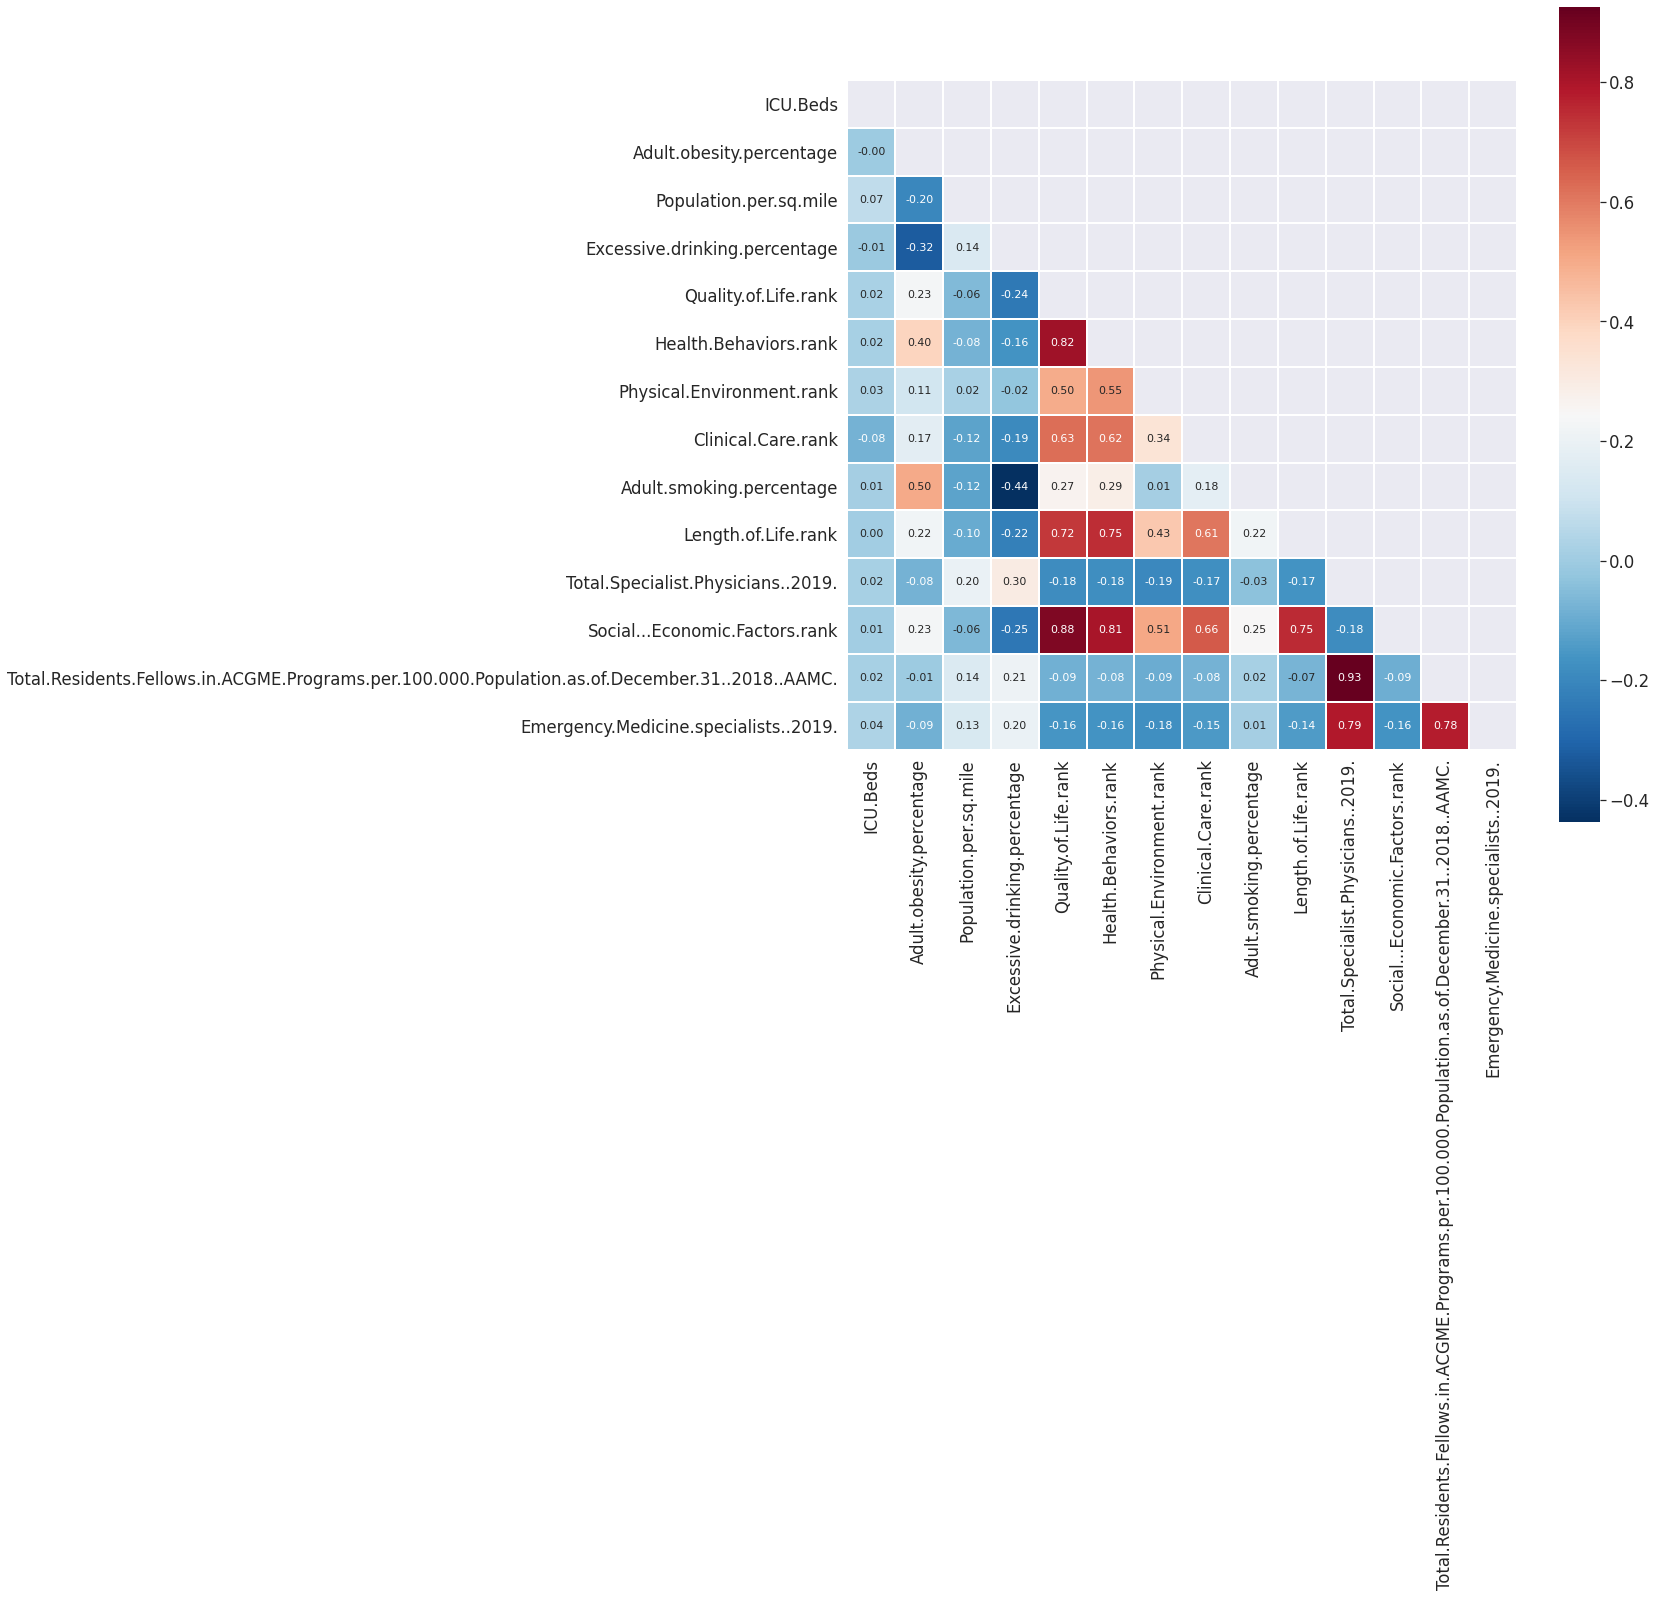

In [0]:
# Diplay a correlation matrix of all variables.

# Get correlations.
corr_vars = Importances_df['Name'][:14]
cor_mat = df[corr_vars].corr()

# Creaste a mask for hiding upper triangle (so that each correlation appears once and not twice).
mask = np.zeros_like(cor_mat, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

# Display correlation matrix.
fig, ax = plt.subplots(figsize=(15, 15))
# sns.heatmap(cor_mat, square=True, mask=mask, linewidths=1, cmap="RdBu_r") # clean
sns.heatmap(cor_mat, square=True, mask=mask, linewidths=1, annot=True, fmt='.2f', annot_kws={'size': 11}, cmap="RdBu_r") # with r values

## Modeling

## Add lock-down length as an additional feature.

In [0]:
# Upload data file.
uploaded = files.upload()

Saving States_Lock-down_Lengh.csv to States_Lock-down_Lengh.csv


In [0]:
# Read into a data frame.
lock_down_length_df = pd.read_csv("States_Lock-down_Lengh.csv", na_values='#N/A')

In [26]:
def regression_fit(model, X_train, y_train, X_test, y_test):
    '''Fit and evaluate a regression model'''
    # Fit model
    model.fit(X_train, y_train)
    
    # Predict test y values
    y_prediction = model.predict(X_test)

    # Calculate root-mean-square error (RMSE), indicative of diffrences between predicted and obseverd values
    RMSE = np.sqrt(mean_squared_error(y_true = y_test, y_pred = y_prediction))

    # Calcualte R square, indicative of the percentage of variance of the predicted varialbe explained by the model
    R2 = r2_score(y_test,y_prediction)

    return (model, RMSE,R2)

,Alabama,26
0,Alaska,41.0
1,Arizona,46.0
2,Arkansas,NaN
3,California,NaN
4,Colorado,32.0


## 

In [0]:
# Choose training variable (based on gini importance)
train_vars = ['ICU.Beds',
'Adult.obesity.percentage',
'Quality.of.Life.rank',
'Excessive.drinking.percentage',
'Length.of.Life.rank',
'Population.per.sq.mile',
'Clinical.Care.rank',
'Adult.smoking.percentage',
'Total.Specialist.Physicians..2019.',
'Physical.Environment.rank'
]

In [0]:
# Set regresssion models for testing
reg_models = list()

reg_models = [
    ('Linear regression',LinearRegression()),
    ('Bayesian Ridge regression', BayesianRidge()),
    ('Decision tree',DecisionTreeRegressor(max_depth=1500,random_state=0)),
    ('Random forest',RandomForestRegressor(max_depth=1500,random_state=0)),
    ('Gradient boosting',GradientBoostingRegressor(random_state=0)),
    ('Linear regression with Ridge regularization', Ridge()),
    ('Linear regression with Lasso regularization (L1 penalty)',Lasso(random_state=0)),
    ('Linear regression with ElasticNet regularization',ElasticNet(random_state=0))
     ]

In [0]:
# Train models and get test results.
results = pd.DataFrame(columns = ['Model','RMSE','R-squared'])
models = []

for i,model in enumerate(reg_models):
    trained_model, RMSE, R2 = regression_fit(model[1], X_train[train_vars], y_train, X_test[train_vars], y_test)
    results.loc[i] = [model[0],RMSE,R2]
    models.append(trained_model)

In [32]:
# Present test results.
results.sort_values(by='R-squared', ascending=False)

,Model,RMSE,R-squared
4,Gradient boosting,0.181081,0.301578
3,Random forest,0.189479,0.235295
0,Linear regression,0.204031,0.113322
5,Linear regression with Ridge regularization,0.204033,0.113310
1,Bayesian Ridge regression,0.204289,0.111083
7,Linear regression with ElasticNet regularization,0.207197,0.085591
6,Linear regression with Lasso regularization (L...,0.207233,0.085279
2,Decision tree,0.241856,-0.245909


In [0]:
# Train a neural netowrk (MLP)

mlp = MLPRegressor(hidden_layer_sizes=(5,5,5), activation='logistic', 
                   learning_rate='adaptive', solver='lbfgs', max_iter=2000, 
                   learning_rate_init=.001, random_state=10)

mlp.fit(X_train[train_vars],y_train)

predict_train = mlp.predict(X_train[train_vars])
predict_test = mlp.predict(X_test[train_vars])

In [0]:
# Calculate root-mean-square error (RMSE), indicative of diffrences between predicted and obseverd values
RMSE = np.sqrt(mean_squared_error(y_true = y_test, y_pred = predict_test))

# Calcualte R square, indicative of the percentage of variance of the predicted varialbe explained by the model
R2 = r2_score(y_test,predict_test)

print(RMSE,R2)
results.loc[i+1] = ['Multilayer Perceptron', RMSE, R2]

0.20307286963605473 0.12163169362718629


In [0]:
# Write the results DataFrame to CSV file
with open('/gdrive/My Drive/results.csv', 'w') as f:
  results.to_csv(f)

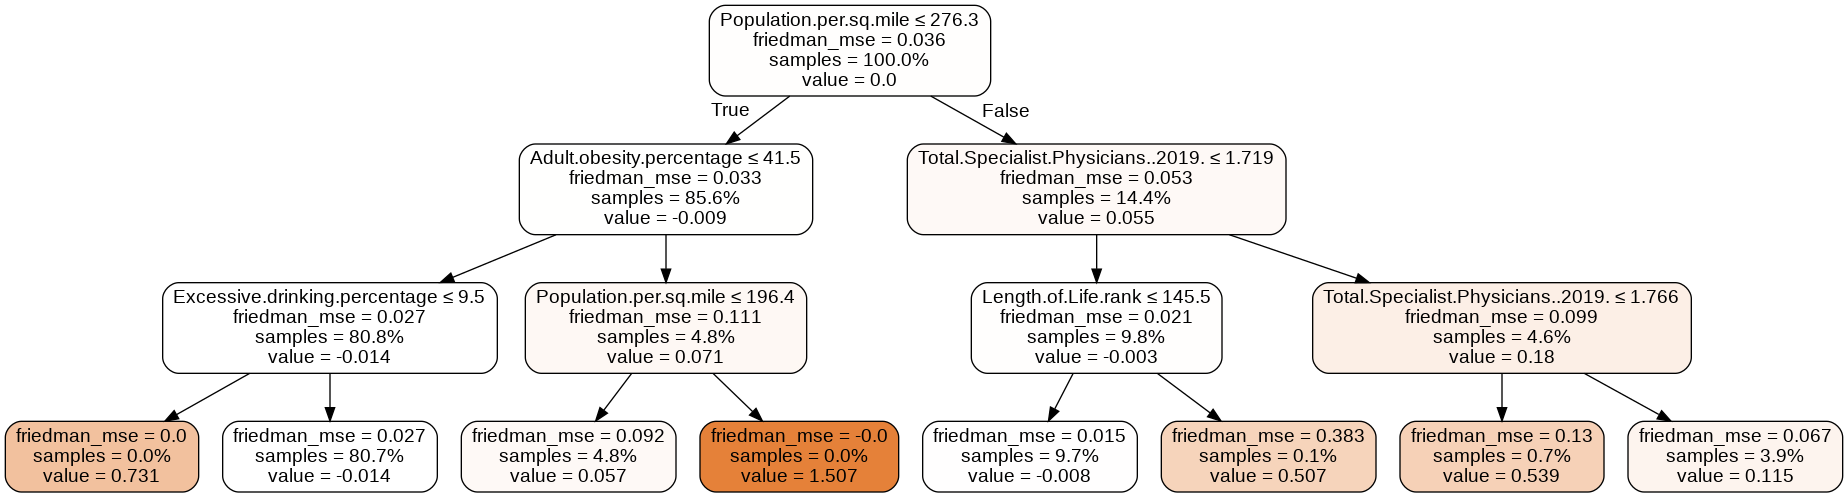

In [74]:
# Plot an example tree from the Gradient boosting model

sub_tree =  models[4].estimators_[10, 0]
dot_data = tree.export_graphviz(
    sub_tree,
    out_file=None, filled=True,
    rounded=True,  
    special_characters=True,
    proportion=True,
    feature_names=X_train[train_vars].columns
)

graph = pydotplus.graph_from_dot_data(dot_data)  
Image(graph.create_png())